# Astronomy 8824 - Numerical and Statistical Methods in Astrophysics

## Introduction to Clustering

These notes are for the course Astronomy 8824: Numerical and Statistical Methods in Astrophysics and were written by Paul Martini. 

#### Background reading: 
- Statistics, Data Mining, and Machine Learning in Astronomy, Chapter 6
- https://scikit-learn.org/stable/modules/clustering.html

In [1]:
import math
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import astropy
import sys, os
from scipy.stats import norm
from sklearn.neighbors import KernelDensity, KDTree
from sklearn.utils.fixes import parse_version
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, MeanShift
from sklearn import preprocessing

import urllib
from astropy.io import fits

# matplotlib settings 
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

### Clustering

Clustering methods are used to identify various regions within a pdf. One can then use the pdfs for different regions to assign a probability that each point is associated with a given region, which is used for classification. 

Clustering methods are split into unsupervised and supervised methods. Unsupervised methods do not use prior information about the structure of potential clusters in the data, while supervised methods do.

### K-means Clustering

K-means clustering is one of the simpler forms of clustering. This algorithm aims to partition $N$ data sets into $K$ distinct subsets $C_k$, each of which contains $N_k$ points. The partition algorithm minimizes the distance between each point in a subset $C_k$ and the mean position $\mu_k$ of all points in that subset:

$$
\sum^K_{k=1} \sum_{i \in C_k} || x_i - \mu_k||^2
$$

The procedure is to start with some set of $\mu_k$, and then assign each point to a cluster based on proximity to the $\mu_k$. Once all points are assigned, compute new $\mu_k$ based on each subset $C_k$ and  reassign the points. This continues until no assignments change. 

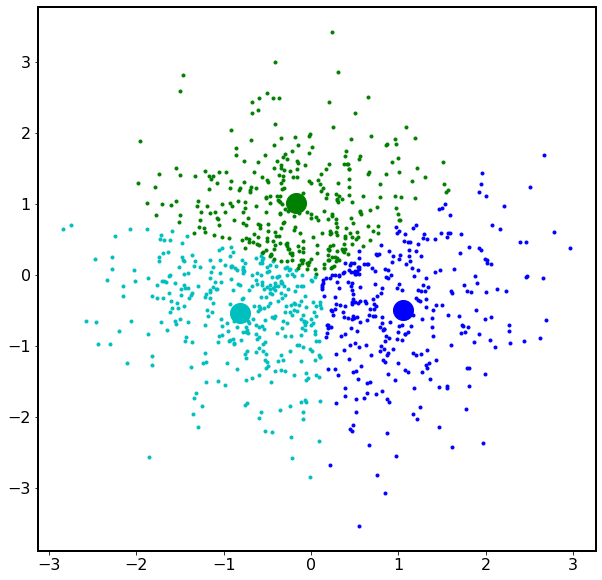

In [2]:
X = np.random.normal(size=(1000, 2))
clf = KMeans(n_clusters=3, n_init=1)
clf.fit(X)
centers = clf.cluster_centers_
labels=clf.predict(X)

plt.figure(figsize=(10,10))
for i in range(len(labels)):
    x = X.T[0]
    y = X.T[1]
    if labels[i] == 0:
        plt.plot(x[i], y[i], 'b.')
    elif labels[i] == 1:
        plt.plot(x[i], y[i], 'g.')
    elif labels[i] == 2: 
        plt.plot(x[i], y[i], 'c.')
  

plt.plot(centers.T[0][0], centers.T[1][0], 'bo', ms=20)
plt.plot(centers.T[0][1], centers.T[1][1], 'go', ms=20)
plt.plot(centers.T[0][2], centers.T[1][2], 'co', ms=20)

There is not guarantee that this process will converge on the optimal solution, so a reasonable procedure is to run this procedure multiple times with different starting points. The default in sklearn is n_init = 10. There are also various options for the initial conditions. One simple approach is to randomly choose the locations of the clusters, while another is to start with the centroids that are relatively well separated. This latter approach can produce faster convergence. 

In [3]:
# Apply K-Means clustering to the Segue data

from astroML.datasets import fetch_sdss_sspp
# Get the Segue Stellar Parameters Pipeline data
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T
# truncate dataset for speed
X = X[::15]

(-0.02, 0.56)

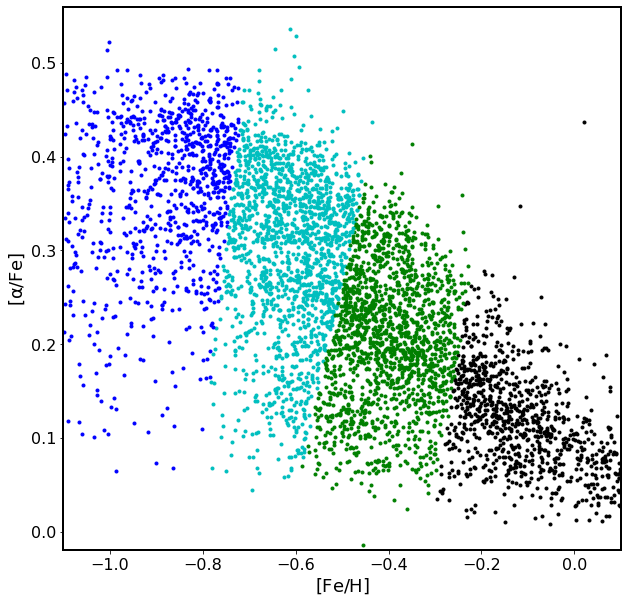

In [4]:
clf = KMeans(n_clusters=4)
clf.fit(X)
centers = clf.cluster_centers_
labels=clf.predict(X)

plt.figure(figsize=(10,10))
for i in range(len(labels)):
    x = X.T[0]
    y = X.T[1]
    if labels[i] == 0:
        plt.plot(x[i], y[i], 'b.')
    elif labels[i] == 1:
        plt.plot(x[i], y[i], 'g.')
    elif labels[i] == 2:
        plt.plot(x[i], y[i], 'c.')
    elif labels[i] == 3:
        plt.plot(x[i], y[i], 'k.')
  
plt.xlabel(r'$\rm [Fe/H]$')
plt.ylabel(r'$\rm [\alpha/Fe]$')
plt.xlim(-1.101, 0.101)
plt.ylim(-0.02, 0.560)

### Mean Shift

This algorithm identifies the maxima in a discretely sampled density distribution. The candidate maxima are calculated from the mean of the points within some region, and the point positions are shifted based on the local density field to refine the centroids. 

At each iteration of the algorithm, one calculates a kernel density estimate $\hat{p}$ from the data $x_i$ and then the log of the gradient of the density field $\nabla \hat{p} \log (x_i)$. Each point is then moved after each iteration $t$ such that:

$$
x^{t+1}_{i} = x^t_i + a \nabla \log \hat{p} (x^{t}_i)
$$

This means the points move in the direction specified by the local gradient in the density field. Points that are in relatively low-density regions will move more than points that are in relatively high-density regions. Eventually all of the points end up associated with some number of peaks. 

The bandwidth is the only parameter, and this specifies the size of the search region to identify points associated with a particular cluster. 

/Users/martini.10/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/martini.10/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


[-1  0  1]
0.4
number of estimated clusters : 2


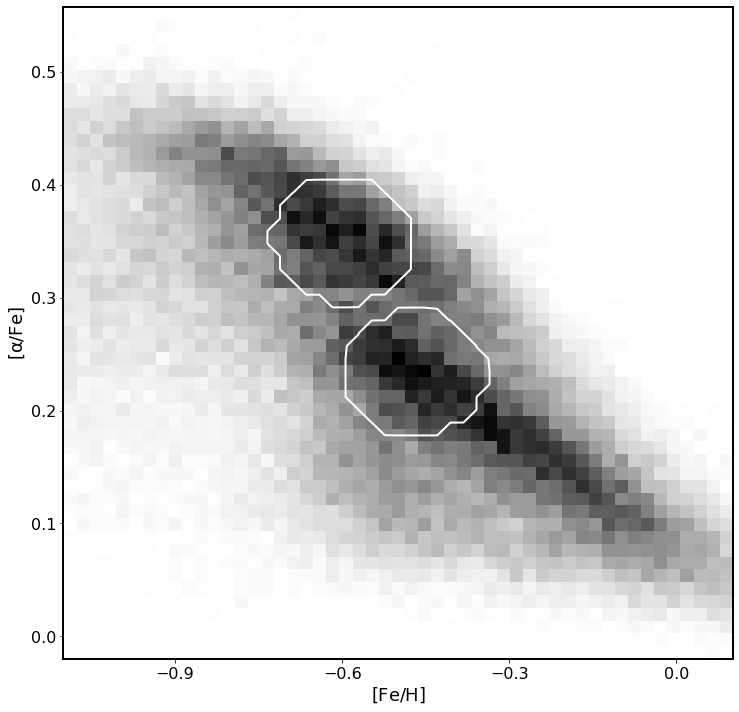

In [5]:
# https://www.astroml.org/book_figures_1ed/chapter6/fig_meanshift_metallicity.html
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import preprocessing

from astroML.datasets import fetch_sdss_sspp

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
# 
# from astroML.plotting import setup_text_plots
# setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Get the data
np.random.seed(0)
data = fetch_sdss_sspp(cleaned=True)

# cut out some additional strange outliers
data = data[~((data['alphFe'] > 0.4) & (data['FeH'] > -0.3))]

X = np.vstack([data['FeH'], data['alphFe']]).T

#----------------------------------------------------------------------
# Compute clustering with MeanShift
#
# We'll work with the scaled data, because MeanShift finds circular clusters

X_scaled = preprocessing.scale(X)

# The following bandwidth can be automatically detected using
# the routine estimate_bandwidth().  Because bandwidth estimation
# is very expensive in memory and computation, we'll skip it here.

#bandwidth = estimate_bandwidth(X)
bandwidth = 0.4

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False)
ms.fit(X_scaled)

labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print( labels_unique)
print(bandwidth)
print("number of estimated clusters : {}".format(n_clusters))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

# plot density
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'], 51)

ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

# plot clusters
colors = ['b', 'g', 'r', 'k']

for i in range(n_clusters):
    Xi = X[ms.labels_ == i]
    H, b1, b2 = np.histogram2d(Xi[:, 0], Xi[:, 1], (FeH_bins, alphFe_bins))

    bins = [0.1]

    ax.contour(0.5 * (FeH_bins[1:] + FeH_bins[:-1]),
               0.5 * (alphFe_bins[1:] + alphFe_bins[:-1]),
               H.T, bins, colors='w')

ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()

### Correlation Functions

Correlation functions measure the extent to which the distribution of some data deviate from a random distribution. 

The most common form of correlation function is the autocorrelation function, which is the correlation function for one population of sources, e.g. galaxies. This is distinct from the cross-correlation function, with is the correlation function between two populations of sources, e.g. galaxies and quasars. 

The correlation function is commonly defined as the excess probability of finding pairs of points with some separatation $r_{12}$ relative to a random distribution. For a population with intrinsic density $\rho$, the probability of finding source one in volume element $dV_1$ and source two in volume element $dV_2$ is

$$
dP_{12} = \rho^2 dV_1 dV_2 (1 + \xi(r_{12}))
$$

where $\xi(r)$ is called the two-point correlation function. If the population of sources is distributed randomly, then $\xi(r) = 0$. 

The correlation function is the Fourier transform of the power spectrum:

$$
\xi(r) = \frac{1}{2\pi^2} \int dk\, k^2\, P(k)\, \frac{sin(kr)}{kr}
$$

and the quantity $k$ is called the wavenumber. This is related to the wavelength or scale of a fluctuation by $k = 2\pi/\lambda$. 

Another way to express the correlation function is in terms of the density of sources:

$$
\xi(r) = \left< \frac{\delta \rho(x)}{\rho} \frac{\rho(x + r)}{\rho} \right>
$$

where the density contrast $\delta \rho(x) / \rho = (\rho - \bar{\rho})/\rho$ and $\bar{\rho}$ is the mean density. 

A common parameterization of the correlation function is:

$$
\xi(r) = \left( \frac{r}{r_0} \right)^{-\gamma} 
$$

where $r_0$ is called the correlation length and $\gamma$ is the power-law slope. 

It is possible to define higher order correlation functions, such as the three-point function, or the four-point function. For example, the three-point function is:

$$
dP_{123} = \rho^3 dV_1 dV_2 dV_3 (1 + \xi(r_{12}) + \xi(r_{23}) + \xi(r_{13} + \zeta(r_{12}, r_{23}, r_{13})
$$

and $\zeta$ is called the reduced three-point function. 

For purely Gaussian fluctuations, the three-point correlation function is zero. Simple inflation models do predict Gaussian, or nearly Gaussian, fluctuations, so the three-point function is a probe of inflationary models and other factors that may cause the power spectrum to deviate from being Gaussian. 

### Computation of the Correlation Function

There are many ways to measure the correlation function. This is not straightforward because datasets typically do not have completely smooth selection functions. For example, survey footprints may have complex boundaries and holes, and may have variations in sensitivity. The existence of these factors complicate the definition of an uncorrelated population, and so it is common practice to simulate a purely random distribution of points that sample the survey footprint. 

One simply way to estimate the correlation function is:

$$
\xi(r) = \frac{DD(r)}{RR(r)} - 1
$$

where $DD(r)$ and $RR(r)$ are the number of data pairs and random pairs with separation $r$, respectively.

Perhaps the most common is the Landy-Szalay estimator: 

$$
\xi(r) = \frac{ DD(r) - 2 DR(r) + RR(r)}{RR(r)}
$$

The quantity $DR(r)$ is the number of data - random pairs at separation $r$. This estimator has better variance and is less suspectible to edge effects than the previous formula. 

Here is an implemention of the two-point correlation function from astroML

In [6]:
# https://www.astroml.org/book_figures/chapter6/fig_correlation_function.html

# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function, division

#import numpy as np
#from matplotlib import pyplot as plt

from astroML.utils.decorators import pickle_results
from astroML.datasets import fetch_sdss_specgals
from astroML.correlation import bootstrap_two_point_angular

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.

#if "setup_text_plots" not in globals():
#    from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Get data and do some quality cuts
data = fetch_sdss_specgals()
m_max = 17.7

# redshift and magnitude cuts
data = data[data['z'] > 0.08]
data = data[data['z'] < 0.12]
data = data[data['petroMag_r'] < m_max]

# RA/DEC cuts
RAmin, RAmax = 140, 220
DECmin, DECmax = 5, 45
data = data[data['ra'] < RAmax]
data = data[data['ra'] > RAmin]
data = data[data['dec'] < DECmax]
data = data[data['dec'] > DECmin]

ur = data['modelMag_u'] - data['modelMag_r']
flag_red = (ur > 2.22)
flag_blue = ~flag_red

data_red = data[flag_red]
data_blue = data[flag_blue]

print("data size:")
print("  red gals: ", len(data_red))
print("  blue gals:", len(data_blue))


#------------------------------------------------------------
# Set up correlation function computation
#  This calculation takes a long time with the bootstrap resampling,
#  so we'll save the results.

output = 'correlation_functions.pkl'
@pickle_results(output)
def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1 / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data_red, data_blue]:
        results += bootstrap_two_point_angular(D['ra'],
                                               D['dec'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

(bins, r_corr, r_corr_err, r_bootstraps, b_corr, b_corr_err, b_bootstraps) = compute_results()
bin_centers = 0.5 * (bins[1:] + bins[:-1])

data size:
  red gals:  38017
  blue gals: 16883
@pickle_results: using precomputed results from 'correlation_functions.pkl'


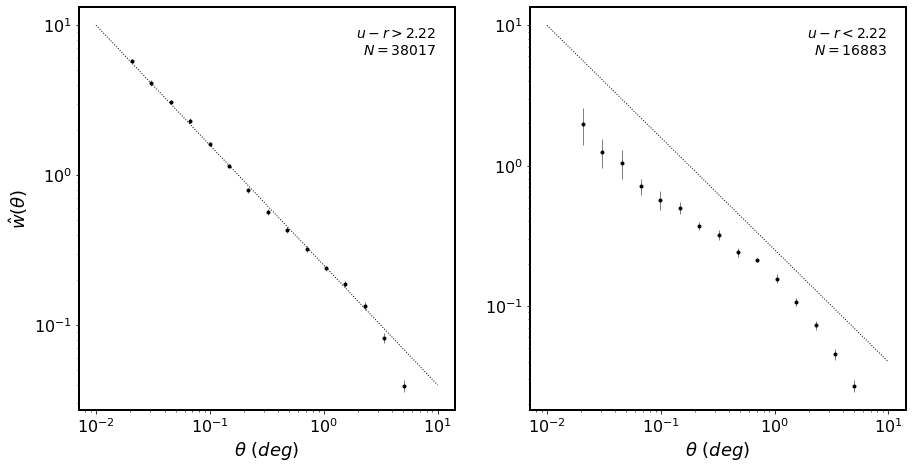

In [7]:
#------------------------------------------------------------
# Plot the results
corr = [r_corr, b_corr]
corr_err = [r_corr_err, b_corr_err]
bootstraps = [r_bootstraps, b_bootstraps]
labels = ['$u-r > 2.22$\n$N=%i$' % len(data_red),
          '$u-r < 2.22$\n$N=%i$' % len(data_blue)]

fig = plt.figure(figsize=(14, 8))
fig.subplots_adjust(bottom=0.2, top=0.9,
                    left=0.13, right=0.95)

for i in range(2):
    ax = fig.add_subplot(121 + i, xscale='log', yscale='log')

    ax.errorbar(bin_centers, corr[i], corr_err[i],
                fmt='.k', ecolor='gray', lw=1)

    t = np.array([0.01, 10])
    ax.plot(t, 10 * (t / 0.01) ** -0.8, ':k', linewidth=1)

    ax.text(0.95, 0.95, labels[i],
            ha='right', va='top', transform=ax.transAxes)
    ax.set_xlabel(r'$\theta\ (deg)$')
    if i == 0:
        ax.set_ylabel(r'$\hat{w}(\theta)$')


plt.show()

#### Anatomy of the calculation

Here is a very simple implementation of the Landy-Szalay estimator with two random samples to show the main steps

In [8]:
# Generate two random samples and call one the data
np.random.seed(1216)
ND = 10000
NR = 10000
size = 10
data = size*np.random.random_sample(size=(ND, 2))
randoms = size*np.random.random_sample(size=(NR, 2))

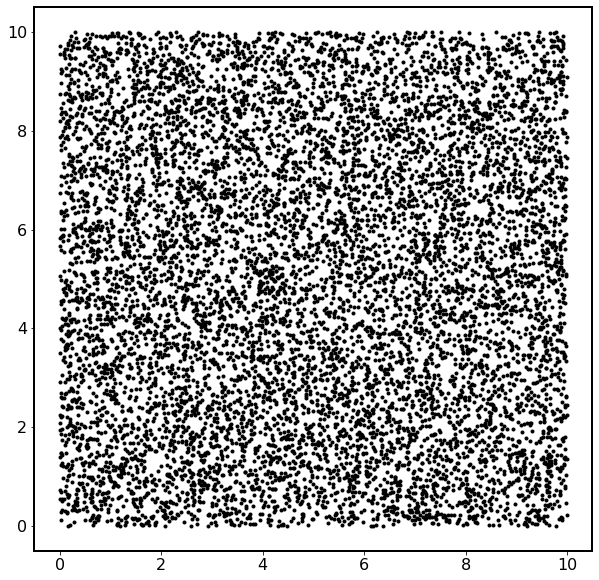

In [9]:
# Plot the data 
plt.figure(figsize=(10,10))
plt.plot(data.T[0], data.T[1], 'k.')

In [10]:
def lsestimate(data, randoms):
    TreeD = KDTree(data)
    TreeR = KDTree(randoms)

    rmin = (1/data.max())
    rmax = (np.sqrt(2)*data.max())
    rbins = 10 ** np.linspace(np.log10(rmin), np.log10(rmax), 10)

    # Compute the number of points with distances less than or equal to r
    DD = TreeD.two_point_correlation(data, rbins)
    RR = TreeR.two_point_correlation(randoms, rbins)
    DR = TreeR.two_point_correlation(data, rbins)

    DD = np.diff(DD)
    RR = np.diff(RR)
    DR = np.diff(DR)

    norm = NR/ND

    RR[RR == 0] == 1

    LScorr = ( norm**2 * DD - 2 * norm * DR + RR) / RR

    LScorr[RR==0] = np.nan

    return rbins[:len(LScorr)], LScorr

In [11]:
r, corr = lsestimate(data, randoms)

Text(0, 0.5, '$\\xi(r)$')

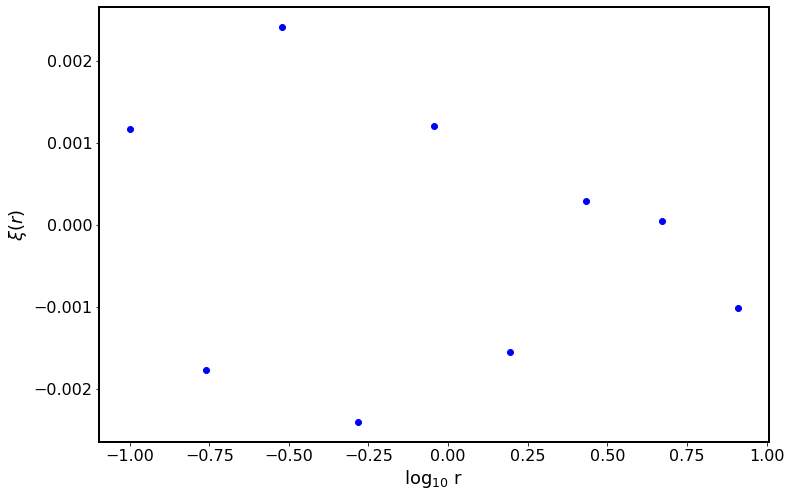

In [12]:
plt.figure(figsize=(12,8))
plt.plot(np.log10(r), corr, 'bo')
plt.xlabel(r'log$_{10}$ r')
plt.ylabel(r'$\xi(r)$')